In [2]:
import torch 
from torch import nn
from torch.utils.data import DataLoader
import numpy as np

from tqdm.auto import tqdm

from torchmetrics import Accuracy

import torchvision
from torchvision import datasets
from torchvision import transforms
from torchvision.transforms import ToTensor

import matplotlib.pyplot as plt



c:\Users\goesp\.virtualenvs\venv_pytorch\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
train_data = datasets.FashionMNIST(root="data",
                                    train=True,
                                    download=True,
                                    transform=ToTensor(),
                                    target_transform=None)

test_data = datasets.FashionMNIST(root="data",
                                    train=False,
                                    download=True,
                                    transform=ToTensor(),
                                    target_transform=None)


tensor([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

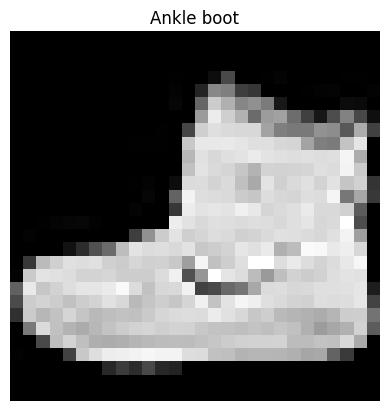

In [4]:
class_names = train_data.classes
image, label = train_data[0]

fig, ax = plt.subplots()

ax.imshow(image.squeeze(), cmap="gray")
ax.set_title(class_names[label])
ax.axis(False)
train_data.targets.unique()




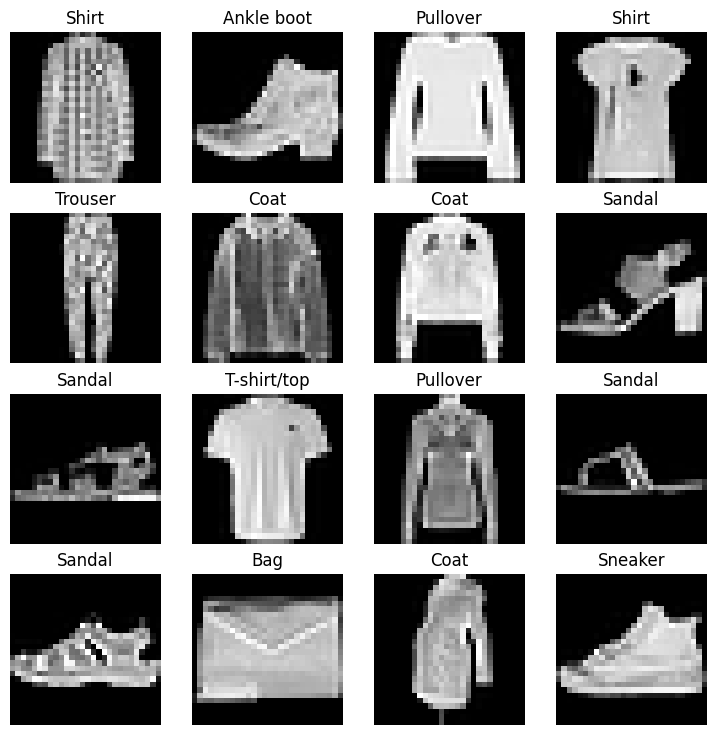

In [5]:


fig, axs = plt.subplots(4, 4)
fig.set_size_inches(9, 9)


for ax in axs.flatten():
    random_idx = torch.randint(0, len(train_data), size=[1]).item()
    image, label = train_data[random_idx]
    ax.imshow(image.squeeze(), cmap="gray")
    ax.set_title(class_names[label])
    ax.axis(False)



In [6]:
BATCH_SIZE = 32

train_dataloader = DataLoader(dataset=train_data,
                              batch_size=BATCH_SIZE,
                              shuffle=True)

test_dataloader = DataLoader(dataset=test_data,
                              batch_size=BATCH_SIZE,
                              shuffle=False)

train_featues_batch, train_labels_batch = next(iter(train_dataloader))
train_featues_batch.shape, train_labels_batch.shape


(torch.Size([32, 1, 28, 28]), torch.Size([32]))

In [7]:
flatten_model = nn.Flatten()
x = train_featues_batch[2]
output = flatten_model(x)
x.shape, output.squeeze().shape

(torch.Size([1, 28, 28]), torch.Size([784]))

In [8]:
class FashionMNISTModelV0(nn.Module):
    def __init__(self,
                 input_shape: int,
                 hidden_units: int,
                 outpu_shape: int):
        super().__init__()
        self.layer_stack = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=input_shape,
                      out_features=hidden_units),
            nn.Linear(in_features=hidden_units,
                      out_features=outpu_shape),
        )
    def forward(self, x):
        return self.layer_stack(x)

In [9]:
torch.manual_seed(42)

model_0 = FashionMNISTModelV0(
    input_shape=28*28,
    hidden_units=16,
    outpu_shape=len(class_names)
).to("cpu")

model_0

FashionMNISTModelV0(
  (layer_stack): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=784, out_features=16, bias=True)
    (2): Linear(in_features=16, out_features=10, bias=True)
  )
)

In [10]:
device = "cuda" if torch.cuda.is_available() else "cpu"

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(params=model_0.parameters(), lr=0.1)

num_classes = len(train_dataloader.dataset.targets.unique())
num_classes
acc = Accuracy(task="multiclass", num_classes=num_classes).to(device)



In [11]:
start = torch.cuda.Event(enable_timing=True)
end = torch.cuda.Event(enable_timing=True)
torch.manual_seed(42)

epochs = 3


start.record()
for epoch in tqdm(range(epochs)):
    train_loss = 0

    for batch, (X, y) in enumerate(train_dataloader):
        model_0.train()

        y_pred = model_0(X)

        loss = loss_fn(y_pred, y)
        train_loss += loss

        optimizer.zero_grad()

        loss.backward()

        optimizer.step()

        if batch % 400 == 0:
            print(f"{batch * len(X)} of {len(train_dataloader.dataset)}" )

    train_loss /= len(train_dataloader)

    test_loss, test_acc = 0, 0

    model_0.eval()
    with torch.inference_mode():
        for X_test, y_test in test_dataloader:

            test_pred = model_0(X_test)

            test_loss += loss_fn(test_pred, y_test)

            test_acc += acc(test_pred, y_test)

        test_loss /= len(test_dataloader)

        test_acc /= len(test_dataloader)

    print(f"\nTrain loss: {train_loss:.4f} | Test loss: {test_loss:.4f}, Test acc: {test_acc:.4f}")
end.record()


  0%|          | 0/3 [00:00<?, ?it/s]

0 of 60000
12800 of 60000
25600 of 60000
38400 of 60000
51200 of 60000


 33%|███▎      | 1/3 [00:09<00:18,  9.16s/it]


Train loss: 0.5851 | Test loss: 0.5062, Test acc: 0.8224
0 of 60000
12800 of 60000
25600 of 60000
38400 of 60000
51200 of 60000


 67%|██████▋   | 2/3 [00:18<00:09,  9.02s/it]


Train loss: 0.4750 | Test loss: 0.4842, Test acc: 0.8307
0 of 60000
12800 of 60000
25600 of 60000
38400 of 60000
51200 of 60000


100%|██████████| 3/3 [00:27<00:00,  9.03s/it]


Train loss: 0.4541 | Test loss: 0.4770, Test acc: 0.8341


In [12]:
torch.manual_seed(42)
def eval_model(model: torch.nn.Module,
               data_loader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               acc_fn):
    loss, acc = 0, 0
    model.eval()
    with torch.inference_mode():
        for X, y in tqdm(data_loader):
            X, y = X.to(device), y.to(device)

            y_pred = model(X)
            loss += loss_fn(y_pred, y)
            acc += acc_fn(y_pred, y)

        loss /= len(data_loader)
        acc /= len(data_loader)

    return {
        "model_name": model.__class__.__name__,
        "model_loss": loss.item(),
        "model_acc": acc.item()
    }

model_0_results = eval_model(model=model_0,
                             data_loader=test_dataloader,
                             loss_fn=loss_fn,
                             acc_fn=acc)
model_0_results

100%|██████████| 313/313 [00:01<00:00, 237.22it/s]


{'model_name': 'FashionMNISTModelV0',
 'model_loss': 0.47699886560440063,
 'model_acc': 0.8340654969215393}

In [13]:
class FashionMNISTModelV1(nn.Module):
    def __init__(self,
                 input_shape: int,
                 hidden_units: int,
                 outpu_shape: int):
        super().__init__()
        self.layer_stack = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=input_shape,
                      out_features=hidden_units),
            nn.ReLU(),
            nn.Linear(in_features=hidden_units,
                      out_features=outpu_shape),
        )
    def forward(self, x: torch.Tensor):
        return self.layer_stack(x)

In [14]:
torch.manual_seed(42)

model_1 = FashionMNISTModelV1(input_shape=28*28,
                              hidden_units=32,
                              outpu_shape=len(class_names)).to(device)


In [15]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(params=model_1.parameters(), lr=0.1)

In [16]:
def train_step(model: torch.nn.Module,
               data_loader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               optimizer: torch.optim.Optimizer,
               acc_fn,
               device: torch.device = "cuda"):

    train_loss, train_acc = 0, 0
    model.train()

    for batch, (X, y) in enumerate(data_loader):
        X, y = X.to(device), y.to(device)

        y_pred = model(X)

        loss = loss_fn(y_pred, y)
        train_loss += loss
        train_acc += acc_fn(y_pred.argmax(dim=1), y)

        optimizer.zero_grad()

        loss.backward()

        optimizer.step()

    train_loss /= len(data_loader)
    train_acc /= len(data_loader)

    print(f"Train loss: {train_loss:.5f} | Train acc: {train_acc:.5f}%")

In [17]:
def test_step(model: torch.nn.Module,
              data_loader: torch.utils.data.DataLoader,
              loss_fn: torch.nn.Module,
              acc_fn,
              device: torch.device = "cuda"):


    test_loss, test_acc = 0, 0

    model.eval()
    with torch.inference_mode():
        for X, y in data_loader:
            X, y = X.to(device), y.to(device)

            test_pred = model(X)

            test_loss += loss_fn(test_pred, y)

            test_acc += acc_fn(test_pred.argmax(dim=1), y)

        test_loss /= len(test_dataloader)

        test_acc /= len(test_dataloader)

    print(f"Test loss: {test_loss:.4f}, Test acc: {test_acc:.4f}")


In [19]:
from timeit import default_timer as timer
start = timer()
epochs = 3

for epoch in tqdm(range(epochs)):
    train_step(model=model_1,
               data_loader=train_dataloader,
               loss_fn=loss_fn,
               optimizer=optimizer,
               acc_fn=acc,
               device=device)

    test_step(model=model_1,
              data_loader=test_dataloader,
              loss_fn=loss_fn,
              acc_fn=acc,
              device=device)
end = timer()
print(end - start)

  0%|          | 0/3 [00:00<?, ?it/s]

Train loss: 0.36909 | Train acc: 0.86637%


 33%|███▎      | 1/3 [00:13<00:27, 13.97s/it]

Test loss: 0.4125, Test acc: 0.8552
Train loss: 0.35256 | Train acc: 0.87178%


 67%|██████▋   | 2/3 [00:28<00:14, 14.44s/it]

Test loss: 0.3987, Test acc: 0.8539
Train loss: 0.34013 | Train acc: 0.87595%


100%|██████████| 3/3 [00:44<00:00, 14.88s/it]

Test loss: 0.3971, Test acc: 0.8589
44.654292899998836
